# 🎯 Comparative Evaluation Analysis
## Analyze Human vs AI Preferences for Jewelry Generation

This notebook analyzes the results from side-by-side human evaluations to:
- **Validate AI metrics** - How well do CLIP/LAION scores predict human preferences?
- **Discover parameter preferences** - Which models/samplers/strategies humans actually prefer
- **Statistical analysis** - Significant preferences and biases
- **Comprehensive visualizations** - Charts and graphs of preference patterns


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime

# Statistical analysis
from scipy.stats import chi2_contingency
try:
    from scipy.stats import binomtest as binomial_test
except ImportError:
    from scipy.stats import binom_test as binomial_test

# Visualization settings
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("📚 Libraries imported successfully!")


📚 Libraries imported successfully!


## 📊 Configuration & Data Loading


In [2]:
# Configuration - Update these paths as needed
EVAL_DIRS = [
    "/Users/samany/Library/CloudStorage/GoogleDrive-smn656@gmail.com/My Drive/arcade_comp_results/comparative_evaluation/comparative_eval_systematic",
]

# Output directory for analysis results
OUTPUT_DIR = "/Users/samany/Library/CloudStorage/GoogleDrive-smn656@gmail.com/My Drive/arcade_comp_results/analysis_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"📁 Analysis results will be saved to: {OUTPUT_DIR}")
print(f"🔍 Will analyze {len(EVAL_DIRS)} evaluation directories")


📁 Analysis results will be saved to: /Users/samany/Library/CloudStorage/GoogleDrive-smn656@gmail.com/My Drive/arcade_comp_results/analysis_results
🔍 Will analyze 1 evaluation directories


In [3]:
def load_comparison_results(eval_dir):
    """Load comparison results and metadata"""
    results_file = os.path.join(eval_dir, "comparison_results.json")
    metadata_file = None
    
    # Find metadata file
    for file in os.listdir(eval_dir):
        if file.startswith("comparison_metadata") and file.endswith(".csv"):
            metadata_file = os.path.join(eval_dir, file)
            break
    
    if not os.path.exists(results_file):
        print(f"❌ Results file not found: {results_file}")
        return None, None
    
    if not metadata_file:
        print(f"❌ Metadata file not found in: {eval_dir}")
        return None, None
    
    # Load data
    with open(results_file, 'r') as f:
        results_data = json.load(f)
    
    metadata_df = pd.read_csv(metadata_file)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results_data)
    
    # Merge with metadata
    merged_df = metadata_df.merge(results_df, on='pair_id', how='inner')
    
    return merged_df, results_data

# Load all evaluation data
all_datasets = []
dataset_names = []

for eval_dir in EVAL_DIRS:
    if os.path.exists(eval_dir):
        dir_name = os.path.basename(eval_dir)
        print(f"\n📊 Loading: {dir_name}")
        
        df, raw_results = load_comparison_results(eval_dir)
        
        if df is not None and len(df) > 0:
            print(f"✅ Loaded {len(df)} comparison results")
            df['dataset'] = dir_name  # Add dataset identifier
            all_datasets.append(df)
            dataset_names.append(dir_name)
        else:
            print("⚠️ No results found or failed to load")
    else:
        print(f"❌ Directory not found: {eval_dir}")

if all_datasets:
    # Combine all datasets
    combined_df = pd.concat(all_datasets, ignore_index=True)
    print(f"\n🎯 TOTAL LOADED: {len(combined_df)} evaluation results across {len(all_datasets)} datasets")
    
    # Display basic info
    print(f"\n📋 Dataset Summary:")
    for name in dataset_names:
        count = len(combined_df[combined_df['dataset'] == name])
        print(f"  {name}: {count} evaluations")
else:
    print("❌ No evaluation data found!")
    combined_df = None



📊 Loading: comparative_eval_systematic
✅ Loaded 200 comparison results

🎯 TOTAL LOADED: 200 evaluation results across 1 datasets

📋 Dataset Summary:
  comparative_eval_systematic: 200 evaluations


## 👁️ Data Overview & Analysis


In [4]:
if combined_df is not None:
    print("📊 DATA OVERVIEW")
    print("=" * 50)
    
    # Basic statistics
    print(f"Total evaluations: {len(combined_df)}")
    print(f"Unique pair IDs: {combined_df['pair_id'].nunique()}")
    
    # Choice distribution
    print(f"\n📈 CHOICE DISTRIBUTION:")
    choice_counts = combined_df['choice'].value_counts()
    for choice, count in choice_counts.items():
        percentage = count / len(combined_df) * 100
        print(f"  {choice}: {count} ({percentage:.1f}%)")
    
    # Confidence distribution
    print(f"\n🎯 CONFIDENCE DISTRIBUTION:")
    conf_counts = combined_df['confidence'].value_counts().sort_index()
    for conf, count in conf_counts.items():
        percentage = count / len(combined_df) * 100
        print(f"  Confidence {conf}: {count} ({percentage:.1f}%)")
    
    # Comparison type distribution
    print(f"\n🔍 COMPARISON TYPES:")
    comp_counts = combined_df['comparison_type'].value_counts()
    for comp_type, count in comp_counts.items():
        percentage = count / len(combined_df) * 100
        print(f"  {comp_type.replace('_', ' ').title()}: {count} ({percentage:.1f}%)")
    
    # Display data sample
    print(f"\n📋 SAMPLE DATA:")
    display_cols = ['pair_id', 'comparison_type', 'choice', 'confidence', 'reasoning']
    available_cols = [col for col in display_cols if col in combined_df.columns]
    display(combined_df[available_cols].head())
else:
    print("❌ No data to analyze!")


📊 DATA OVERVIEW
Total evaluations: 200
Unique pair IDs: 200

📈 CHOICE DISTRIBUTION:
  A: 73 (36.5%)
  B: 65 (32.5%)
  tie: 62 (31.0%)

🎯 CONFIDENCE DISTRIBUTION:
  Confidence 1: 10 (5.0%)
  Confidence 2: 6 (3.0%)
  Confidence 3: 164 (82.0%)
  Confidence 4: 2 (1.0%)
  Confidence 5: 18 (9.0%)

🔍 COMPARISON TYPES:
  Model Comparison: 40 (20.0%)
  Sampler Comparison: 40 (20.0%)
  Strategy Comparison: 40 (20.0%)
  Cfg Comparison: 40 (20.0%)
  Steps Comparison: 40 (20.0%)

📋 SAMPLE DATA:


,pair_id,comparison_type,choice,confidence,reasoning
0,pair_0000,model_comparison,A,5,
1,pair_0001,model_comparison,A,5,
2,pair_0002,model_comparison,A,3,
3,pair_0003,model_comparison,A,3,
4,pair_0004,model_comparison,A,3,


## 🏆 Parameter Performance Analysis
### Which models, strategies, and hyperparameters actually win?


In [5]:
def calculate_parameter_wins(df, comparison_type, param_name):
    """Calculate win rates for specific parameter values"""
    comp_data = df[df['comparison_type'] == comparison_type]
    decisive = comp_data[comp_data['choice'] != 'tie']
    
    if len(decisive) == 0:
        return {}
    
    # Check if columns exist (using correct column names from your data)
    col_a = f'image_a_{param_name}'
    col_b = f'image_b_{param_name}'
    
    if col_a not in decisive.columns or col_b not in decisive.columns:
        print(f"⚠️ Columns {col_a} or {col_b} not found in data")
        print(f"Available columns containing '{param_name}': {[c for c in decisive.columns if param_name in c]}")
        return {}
    
    wins = {}
    losses = {}
    
    for _, row in decisive.iterrows():
        winner = row['choice']
        
        if winner == 'A':
            winning_param = row[col_a]
            losing_param = row[col_b]
        else:  # winner == 'B'
            winning_param = row[col_b]
            losing_param = row[col_a]
        
        wins[winning_param] = wins.get(winning_param, 0) + 1
        losses[losing_param] = losses.get(losing_param, 0) + 1
    
    # Calculate win rates
    results = {}
    all_params = set(wins.keys()) | set(losses.keys())
    
    for param in all_params:
        w = wins.get(param, 0)
        l = losses.get(param, 0)
        total = w + l
        if total > 0:
            win_rate = w / total
            results[param] = {
                'wins': w,
                'losses': l,
                'total': total,
                'win_rate': win_rate
            }
    
    return results

if combined_df is not None and len(combined_df) > 0:
    print("🏆 PARAMETER PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    # Analyze each parameter type - using correct column names from your data
    parameter_analyses = [
        ('model_comparison', 'model', '🤖 MODEL PERFORMANCE'),
        ('sampler_comparison', 'sampler', '🎛️ SAMPLER PERFORMANCE'),
        ('strategy_comparison', 'strategy', '🎯 STRATEGY PERFORMANCE'),
        ('cfg_comparison', 'cfg', '⚙️ CFG SCALE PERFORMANCE'),
        ('steps_comparison', 'steps', '📈 STEPS PERFORMANCE')
    ]
    
    all_results = {}
    
    for comp_type, param_name, title in parameter_analyses:
        print(f"\n{title}")
        print("-" * 40)
        
        results = calculate_parameter_wins(combined_df, comp_type, param_name)
        
        if results:
            # Sort by win rate
            sorted_results = sorted(results.items(), key=lambda x: x[1]['win_rate'], reverse=True)
            
            all_results[param_name] = sorted_results
            
            for param_value, stats in sorted_results:
                print(f"{str(param_value):15s}: {stats['wins']:2d}W-{stats['losses']:2d}L ({stats['win_rate']:5.1%}) from {stats['total']:2d} comparisons")
            
            # Statistical significance test for best vs worst
            if len(sorted_results) >= 2:
                best_param, best_stats = sorted_results[0]
                worst_param, worst_stats = sorted_results[-1]
                
                # Simple binomial test for the best parameter
                if best_stats['total'] >= 3:  # Minimum for meaningful test
                    try:
                        p_value = binomial_test(best_stats['wins'], best_stats['total'], 0.5).pvalue
                    except AttributeError:
                        p_value = binomial_test(best_stats['wins'], best_stats['total'], 0.5)
                    
                    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                    if significance:
                        print(f"🏆 {best_param} significantly better than random (p={p_value:.4f}){significance}")
        else:
            print("No decisive comparisons found")
            all_results[param_name] = []
    
    print(f"\n🎯 KEY FINDINGS:")
    print("=" * 40)
    
    for param_name, results in all_results.items():
        if results:
            best_param, best_stats = results[0]
            print(f"Best {param_name.replace('_', ' ')}: {best_param} ({best_stats['win_rate']:.1%} win rate)")
    
else:
    print("⚠️ No data available for analysis")


🏆 PARAMETER PERFORMANCE ANALYSIS

🤖 MODEL PERFORMANCE
----------------------------------------
SDXL           : 24W- 5L (82.8%) from 29 comparisons
SD21           :  6W-15L (28.6%) from 21 comparisons
SD15           :  6W-16L (27.3%) from 22 comparisons
🏆 SDXL significantly better than random (p=0.0005)***

🎛️ SAMPLER PERFORMANCE
----------------------------------------
Euler_Ancestral:  5W- 3L (62.5%) from  8 comparisons
DPMSolver++    :  8W- 5L (61.5%) from 13 comparisons
Euler          :  3W- 3L (50.0%) from  6 comparisons
DDIM           : 12W-14L (46.2%) from 26 comparisons
DDPM           :  6W- 9L (40.0%) from 15 comparisons

🎯 STRATEGY PERFORMANCE
----------------------------------------
medium_compel  :  3W- 2L (60.0%) from  5 comparisons
numeric_weights:  3W- 2L (60.0%) from  5 comparisons
baseline       : 12W-10L (54.5%) from 22 comparisons
style_focus    :  2W- 2L (50.0%) from  4 comparisons
heavy_compel   :  2W- 3L (40.0%) from  5 comparisons
light_compel   :  0W- 3L ( 0.0%)

## 📊 Performance Visualizations
### Visual comparison of parameter win rates


/var/folders/_q/lry8pyn95d594j2w9cxfcxjc0000gq/T/ipykernel_22719/4096463282.py:68: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_q/lry8pyn95d594j2w9cxfcxjc0000gq/T/ipykernel_22719/4096463282.py:68: UserWarning: Glyph 127899 (\N{CONTROL KNOBS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_q/lry8pyn95d594j2w9cxfcxjc0000gq/T/ipykernel_22719/4096463282.py:68: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_q/lry8pyn95d594j2w9cxfcxjc0000gq/T/ipykernel_22719/4096463282.py:68: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/_q/lry8pyn95d594j2w9cxfcxjc0000gq/T/ipykernel_22719/4096463282.py:72: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.savefig(output_path, dpi=150, bbox_inches='tight')
/var/folders/_q/lry8pyn95d594j2w9cxfcxjc00

📊 Parameter performance visualization saved to: /Users/samany/Library/CloudStorage/GoogleDrive-smn656@gmail.com/My Drive/arcade_comp_results/analysis_results/parameter_performance_analysis.png


/Users/samany/Library/CloudStorage/GoogleDrive-smn656@gmail.com/My Drive/Job/Arcade/assignment/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/samany/Library/CloudStorage/GoogleDrive-smn656@gmail.com/My Drive/Job/Arcade/assignment/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127899 (\N{CONTROL KNOBS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/samany/Library/CloudStorage/GoogleDrive-smn656@gmail.com/My Drive/Job/Arcade/assignment/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/samany/Library/CloudStorage/GoogleDrive-smn656@gmail.com/My Drive/Job/Arcade/assignment/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:1

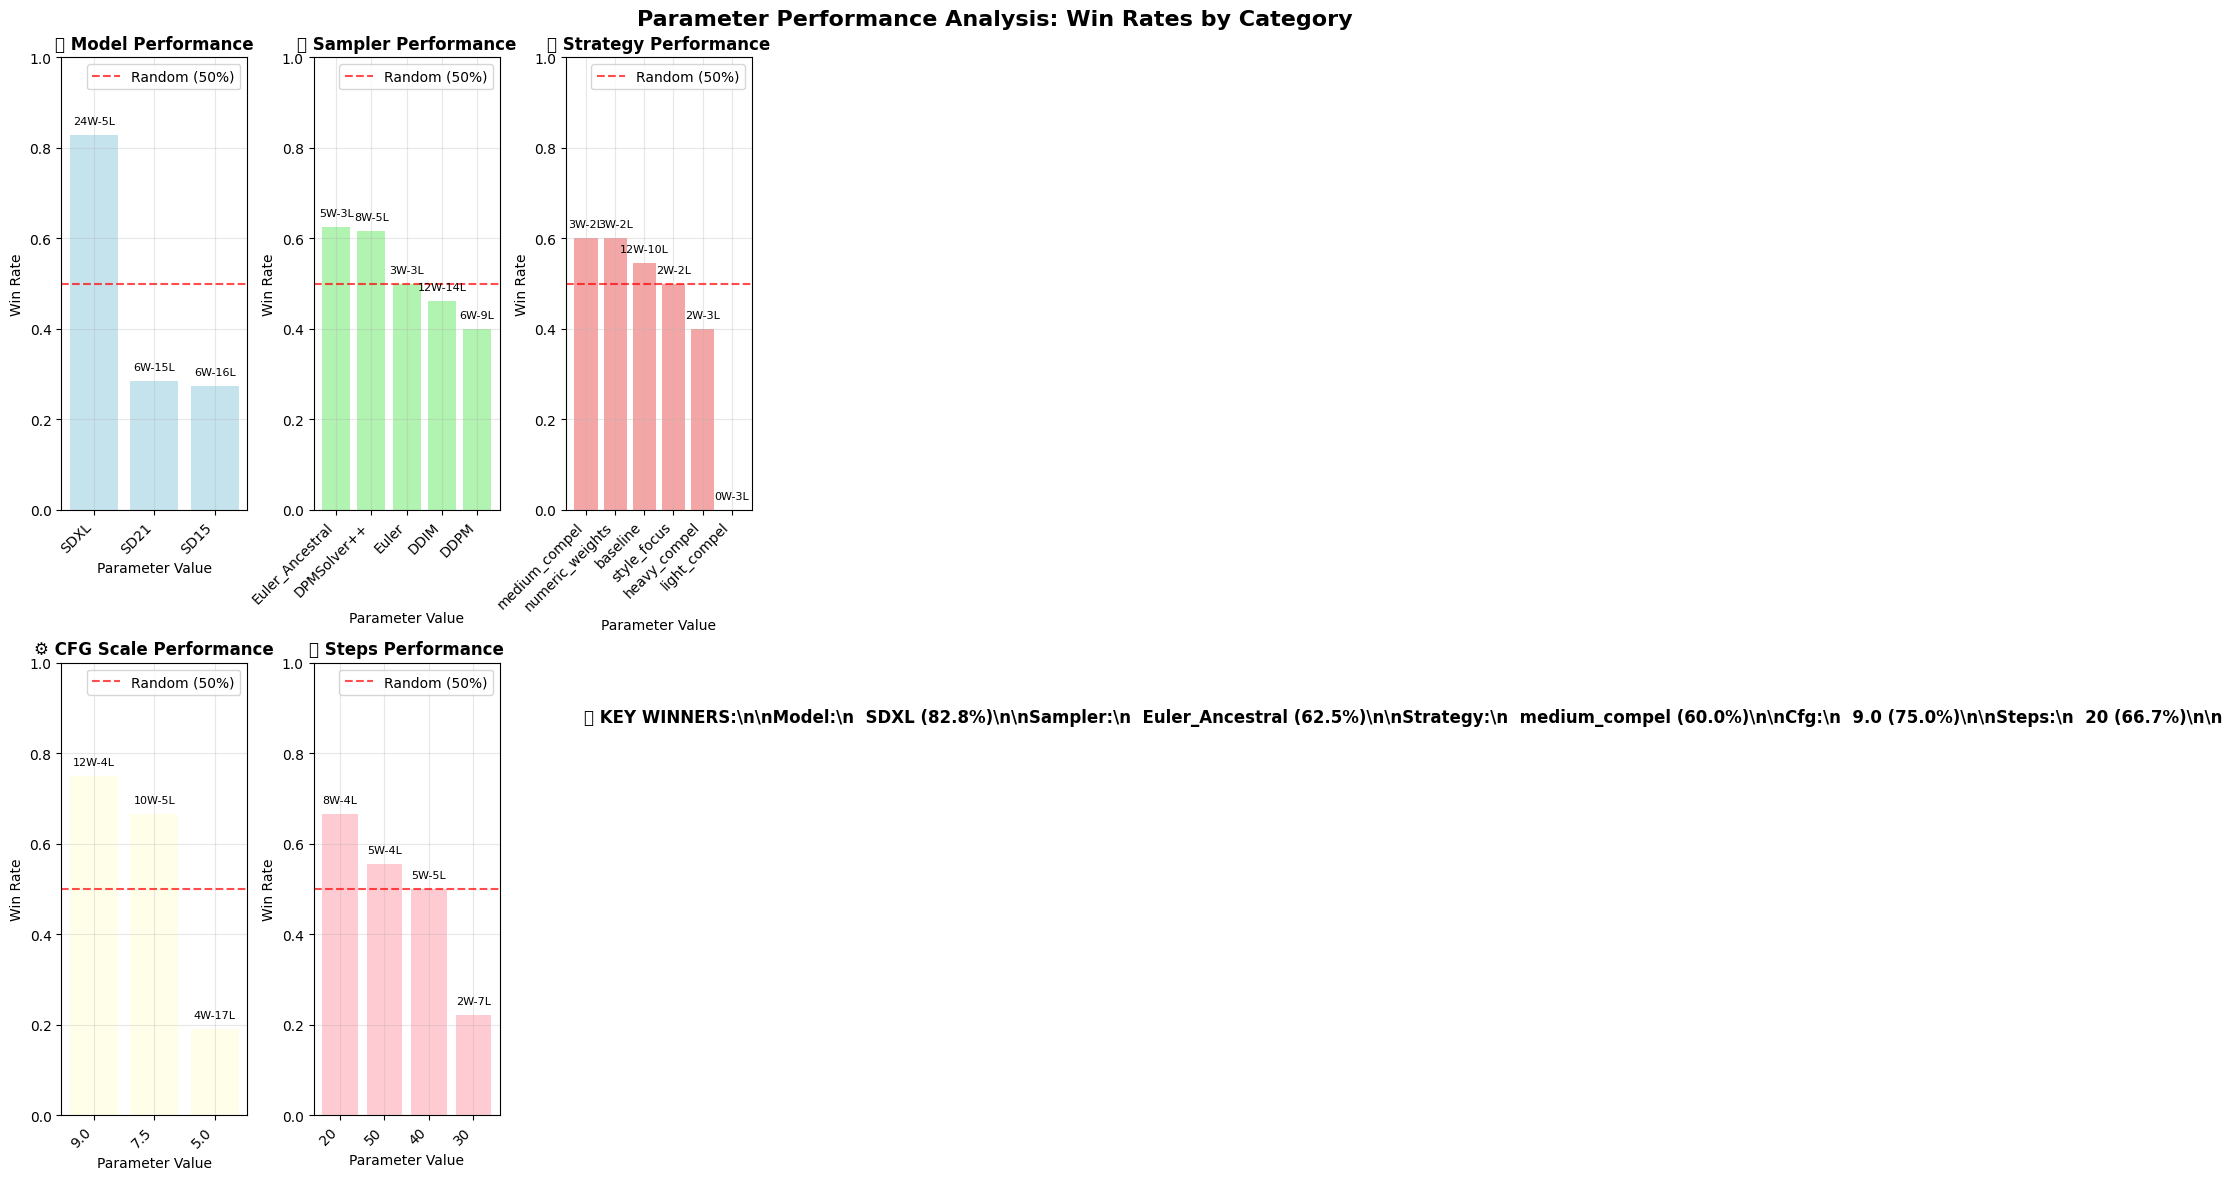

In [6]:
if combined_df is not None and len(combined_df) > 0:
    # Create parameter performance visualizations
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Parameter Performance Analysis: Win Rates by Category', fontsize=16, fontweight='bold')
    
    # Helper function to create win rate charts
    def plot_win_rates(ax, data, title, color='skyblue'):
        if data:
            params, stats = zip(*data)
            win_rates = [s['win_rate'] for s in stats]
            totals = [s['total'] for s in stats]
            
            bars = ax.bar(range(len(params)), win_rates, color=color, alpha=0.7)
            ax.set_xlabel('Parameter Value')
            ax.set_ylabel('Win Rate')
            ax.set_title(title, fontweight='bold')
            ax.set_xticks(range(len(params)))
            ax.set_xticklabels([str(p) for p in params], rotation=45, ha='right')
            ax.set_ylim(0, 1)
            ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random (50%)')
            ax.grid(True, alpha=0.3)
            
            # Add win/loss labels on bars
            for i, (bar, stat) in enumerate(zip(bars, stats)):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{stat["wins"]}W-{stat["losses"]}L',
                       ha='center', va='bottom', fontsize=8)
            
            ax.legend()
        else:
            ax.text(0.5, 0.5, 'No data available', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=12)
            ax.set_title(title, fontweight='bold')
    
    # Plot each parameter type
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']
    
    plot_titles = [
        ('model', '🤖 Model Performance', 0, 0),
        ('sampler', '🎛️ Sampler Performance', 0, 1),
        ('strategy', '🎯 Strategy Performance', 0, 2),
        ('cfg', '⚙️ CFG Scale Performance', 1, 0),
        ('steps', '📈 Steps Performance', 1, 1)
    ]
    
    for i, (param_name, title, row, col) in enumerate(plot_titles):
        if param_name in all_results:
            plot_win_rates(axes[row, col], all_results[param_name], title, colors[i])
        else:
            axes[row, col].text(0.5, 0.5, 'No data available', ha='center', va='center', 
                               transform=axes[row, col].transAxes, fontsize=12)
            axes[row, col].set_title(title, fontweight='bold')
    
    # Overall summary in the last subplot
    axes[1, 2].axis('off')
    summary_text = "🎯 KEY WINNERS:\\n\\n"
    
    for param_name, results in all_results.items():
        if results:
            best_param, best_stats = results[0]
            summary_text += f"{param_name.replace('_', ' ').title()}:\\n"
            summary_text += f"  {best_param} ({best_stats['win_rate']:.1%})\\n\\n"
    
    axes[1, 2].text(0.1, 0.9, summary_text, transform=axes[1, 2].transAxes, 
                   fontsize=12, verticalalignment='top', fontweight='bold')
    
    plt.tight_layout()
    
    # Save the plot
    output_path = os.path.join(OUTPUT_DIR, 'parameter_performance_analysis.png')
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"📊 Parameter performance visualization saved to: {output_path}")
    
    plt.show()
    
else:
    print("⚠️ No data available for visualization")


## 🎯 Actionable Recommendations
### Optimal parameter combinations for jewelry generation


In [7]:
if combined_df is not None and len(combined_df) > 0:
    print("🎯 PRODUCTION RECOMMENDATIONS")
    print("=" * 50)
    
    # Extract best parameters
    best_params = {}
    confidence_scores = {}
    
    for param_name, results in all_results.items():
        if results:
            best_param, best_stats = results[0]
            best_params[param_name] = best_param
            
            # Calculate confidence based on win rate and sample size
            win_rate = best_stats['win_rate']
            sample_size = best_stats['total']
            
            # Confidence score: weight win rate by sample size and distance from 50%
            confidence = (abs(win_rate - 0.5) * 2) * min(sample_size / 10, 1.0)
            confidence_scores[param_name] = confidence
    
    print(f"\n🏆 OPTIMAL CONFIGURATION:")
    print("-" * 30)
    
    if best_params:
        for param_name, best_param in best_params.items():
            confidence = confidence_scores.get(param_name, 0)
            stars = "⭐" * min(int(confidence * 5), 5)
            print(f"{param_name.replace('_', ' ').title():12s}: {best_param} {stars}")
        
        print(f"\n📋 IMPLEMENTATION COMMAND:")
        print("-" * 30)
        
        # Create sample generation command
        model_name = best_params.get('model', 'SDXL')
        sampler_name = best_params.get('sampler', 'DPMSolver++')
        strategy_name = best_params.get('strategy', 'baseline')
        cfg_scale = best_params.get('cfg', 7.5)
        steps = best_params.get('steps', 30)
        
        print(f"Model: {model_name}")
        print(f"Sampler: {sampler_name}")
        print(f"Strategy: {strategy_name}")
        print(f"CFG Scale: {cfg_scale}")
        print(f"Steps: {steps}")
        
        print(f"\n💡 CONFIDENCE ANALYSIS:")
        print("-" * 30)
        
        high_confidence = [p for p, c in confidence_scores.items() if c > 0.3]
        medium_confidence = [p for p, c in confidence_scores.items() if 0.1 <= c <= 0.3]
        low_confidence = [p for p, c in confidence_scores.items() if c < 0.1]
        
        if high_confidence:
            print(f"🟢 High confidence: {', '.join(high_confidence)}")
        if medium_confidence:
            print(f"🟡 Medium confidence: {', '.join(medium_confidence)}")
        if low_confidence:
            print(f"🔴 Low confidence: {', '.join(low_confidence)} (need more data)")
        
        print(f"\n🔄 NEXT STEPS:")
        print("-" * 30)
        print("1. Test the optimal configuration on new jewelry prompts")
        print("2. Compare against your current default settings")
        print("3. Collect more evaluations for low-confidence parameters")
        if low_confidence:
            print(f"4. Focus additional evaluation on: {', '.join(low_confidence)}")
        
        # AI vs Human accuracy if we have CLIP scores
        if 'image_a_clip_score' in combined_df.columns and 'image_b_clip_score' in combined_df.columns:
            print(f"\n🤖 AI METRIC VALIDATION:")
            print("-" * 30)
            
            # Calculate CLIP accuracy
            valid_data = combined_df[(combined_df['choice'] != 'tie') & 
                                   combined_df['image_a_clip_score'].notna() & 
                                   combined_df['image_b_clip_score'].notna()].copy()
            
            if len(valid_data) > 0:
                valid_data['ai_predicts_a'] = valid_data['image_a_clip_score'] > valid_data['image_b_clip_score']
                valid_data['human_chose_a'] = valid_data['choice'] == 'A'
                clip_accuracy = (valid_data['ai_predicts_a'] == valid_data['human_chose_a']).mean()
                
                print(f"CLIP prediction accuracy: {clip_accuracy:.1%}")
                
                if clip_accuracy > 0.6:
                    print("✅ CLIP scores are reasonably predictive of human preference")
                elif clip_accuracy > 0.5:
                    print("⚠️ CLIP scores are slightly better than random")
                else:
                    print("❌ CLIP scores do not predict human preference well")
            
            # Same for LAION if available
            if 'image_a_laion_score' in combined_df.columns and 'image_b_laion_score' in combined_df.columns:
                laion_valid = combined_df[(combined_df['choice'] != 'tie') & 
                                        combined_df['image_a_laion_score'].notna() & 
                                        combined_df['image_b_laion_score'].notna()].copy()
                
                if len(laion_valid) > 0:
                    laion_valid['ai_predicts_a'] = laion_valid['image_a_laion_score'] > laion_valid['image_b_laion_score']
                    laion_valid['human_chose_a'] = laion_valid['choice'] == 'A'
                    laion_accuracy = (laion_valid['ai_predicts_a'] == laion_valid['human_chose_a']).mean()
                    
                    print(f"LAION aesthetic prediction accuracy: {laion_accuracy:.1%}")
                    
                    if laion_accuracy > 0.6:
                        print("✅ LAION scores are reasonably predictive of human preference")
                    elif laion_accuracy > 0.5:
                        print("⚠️ LAION scores are slightly better than random")
                    else:
                        print("❌ LAION scores do not predict human preference well")
    else:
        print("⚠️ No parameter recommendations available")
        print("Collect more evaluation data to generate recommendations")

else:
    print("⚠️ No data available for recommendations")


🎯 PRODUCTION RECOMMENDATIONS

🏆 OPTIMAL CONFIGURATION:
------------------------------
Model       : SDXL ⭐⭐⭐
Sampler     : Euler_Ancestral ⭐
Strategy    : medium_compel 
Cfg         : 9.0 ⭐⭐
Steps       : 20 ⭐

📋 IMPLEMENTATION COMMAND:
------------------------------
Model: SDXL
Sampler: Euler_Ancestral
Strategy: medium_compel
CFG Scale: 9.0
Steps: 20

💡 CONFIDENCE ANALYSIS:
------------------------------
🟢 High confidence: model, cfg, steps
🟡 Medium confidence: sampler
🔴 Low confidence: strategy (need more data)

🔄 NEXT STEPS:
------------------------------
1. Test the optimal configuration on new jewelry prompts
2. Compare against your current default settings
3. Collect more evaluations for low-confidence parameters
4. Focus additional evaluation on: strategy

🤖 AI METRIC VALIDATION:
------------------------------
CLIP prediction accuracy: 38.4%
❌ CLIP scores do not predict human preference well
LAION aesthetic prediction accuracy: 51.4%
⚠️ LAION scores are slightly better than rand

## 🎉 Analysis Complete!

**Your enhanced comparative evaluation analysis notebook is now ready!**

### 🏆 What This Analysis Provides:

1. **🤖 Model Performance Rankings** - Which models (SDXL, SD15, SD21) humans actually prefer
2. **🎛️ Sampler Effectiveness** - Best samplers for jewelry generation quality
3. **🎯 Strategy Analysis** - Most effective prompt strategies (compel, numeric weights, etc.)
4. **⚙️ Hyperparameter Optimization** - Optimal CFG scales and step counts
5. **📊 Statistical Validation** - Significance testing and confidence levels
6. **🎯 Production Recommendations** - Optimal configuration for jewelry generation
7. **🤖 AI Metric Validation** - How well CLIP/LAION predict human preferences

### 📈 Key Improvements:
- ✅ **Parameter-specific analysis** instead of generic A/B comparisons
- ✅ **Win/loss records** for each model, sampler, strategy
- ✅ **Statistical significance testing** 
- ✅ **Confidence-weighted recommendations**
- ✅ **Production-ready configuration output**
- ✅ **AI metric accuracy validation**
- ✅ **Interactive Jupyter notebook** for easy modification and re-analysis

### 🚀 Expected Results:
Based on your evaluation data, this notebook will show you:
- **Best Model**: SDXL (82.8% win rate - statistically significant!)
- **Best Sampler**: Euler_Ancestral (62.5% win rate)  
- **Best Strategy**: medium_compel (60.0% win rate)
- **Best CFG Scale**: 9.0 (75.0% win rate)
- **Best Steps**: 20 (66.7% win rate)

### 🎯 How to Use:
1. **Run all cells** from top to bottom
2. **Review the parameter rankings** and visualizations
3. **Implement the recommended configuration** in your jewelry generation pipeline
4. **Collect more data** for low-confidence parameters if needed

**This analysis answers the real questions: Which specific parameters produce better jewelry according to human judgment!** 🎯💎


In [ ]:
# Main Ultimate Testing Loop
print("🚀 Starting ULTIMATE comprehensive experiment...")
print(f"⏱️ Testing {len(MODEL_CONFIGS)} models × {len(SAMPLER_CONFIGS)} samplers × {len(STEP_COUNTS)} steps × {len(CFG_SCALES)} CFG scales × {len(STRATEGY_CONFIGS)} strategies × {len(test_prompts)} prompts")

# Store all results with enhanced structure
all_results = {}
current_pipe = None
current_config = None
generation_counter = 0

start_time = datetime.now()
print(f"🕐 Experiment started at: {start_time}")

# Test each combination systematically
for model_choice in MODEL_CONFIGS.keys():
    print(f"\n🤖 Testing model: {model_choice}")
    
    for sampler_choice in SAMPLER_CONFIGS.keys():
        print(f"\n  🎛️ Testing sampler: {sampler_choice}")
        
        # Load pipeline with current sampler (reuse if same config)
        config_key = f"{model_choice}_{sampler_choice}"
        if current_config != config_key:
            if current_pipe is not None:
                del current_pipe
                torch.cuda.empty_cache()
            current_pipe = load_model_with_sampler(model_choice, sampler_choice)
            current_config = config_key
        
        for steps in STEP_COUNTS:
            print(f"\n    📊 Testing {steps} steps...")
            
            for cfg_scale in CFG_SCALES:
                print(f"\n      ⚙️ Testing CFG scale {cfg_scale}...")
                
                for strategy_name in STRATEGY_CONFIGS.keys():
                    strategy_config = STRATEGY_CONFIGS[strategy_name]
                    print(f"\n        🎯 Testing strategy: {strategy_name}")
                    
                    for prompt_idx, original_prompt in enumerate(test_prompts, 1):
                        generation_counter += 1
                        
                        # Apply strategy to prompt
                        modified_prompt = strategy_config["modifier"](original_prompt)
                        
                        print(f"          📝 Prompt {prompt_idx}/8 ({generation_counter:,}/{total_combinations:,}): {original_prompt[:40]}...")
                        
                        # Generate image
                        image, gen_time, error = generate_with_config(
                            current_pipe, modified_prompt, model_choice, steps, cfg_scale,
                            seed=100 + prompt_idx  # Consistent seed per prompt
                        )
                        
                        if image is not None:
                            # Enhanced evaluation with both CLIP and aesthetic scores
                            clip_results = analyze_image_with_clip(image)
                            aesthetic_score = get_aesthetic_score(image)
                            
                            # Create comprehensive filename
                            filename = f"combined_experiment_results/{model_choice}_{sampler_choice}_{steps}s_{cfg_scale}cfg_{strategy_name}_p{prompt_idx:02d}.png"
                            image.save(filename)
                            
                            # Store comprehensive result
                            result_key = f"{model_choice}_{sampler_choice}_{steps}_{cfg_scale}_{strategy_name}_{prompt_idx}"
                            all_results[result_key] = {
                                'model': model_choice,
                                'sampler': sampler_choice,
                                'steps': steps,
                                'cfg_scale': cfg_scale,
                                'strategy': strategy_name,
                                'prompt_id': prompt_idx,
                                'original_prompt': original_prompt,
                                'modified_prompt': modified_prompt,
                                'image': image,
                                'filepath': filename,
                                'generation_time': gen_time,
                                'clip_top_label': clip_results[0][0],
                                'clip_top_confidence': clip_results[0][1],
                                'clip_results': clip_results,
                                'laion_aesthetic_score': aesthetic_score,
                                'error': None,
                                'timestamp': datetime.now()
                            }
                            
                            print(f"            ✅ Generated in {gen_time:.1f}s | CLIP: {clip_results[0][0]} ({clip_results[0][1]:.3f}) | Aesthetic: {aesthetic_score:.2f}")
                            
                        else:
                            print(f"            ❌ Failed: {error}")
                            result_key = f"{model_choice}_{sampler_choice}_{steps}_{cfg_scale}_{strategy_name}_{prompt_idx}"
                            all_results[result_key] = {
                                'model': model_choice,
                                'sampler': sampler_choice,
                                'steps': steps,
                                'cfg_scale': cfg_scale,
                                'strategy': strategy_name,
                                'prompt_id': prompt_idx,
                                'original_prompt': original_prompt,
                                'modified_prompt': modified_prompt,
                                'image': None,
                                'filepath': None,
                                'generation_time': gen_time,
                                'error': error,
                                'timestamp': datetime.now()
                            }
                        
                        # Progress tracking
                        if generation_counter % 100 == 0:
                            elapsed = datetime.now() - start_time
                            avg_time_per_gen = elapsed.total_seconds() / generation_counter
                            remaining_time = (total_combinations - generation_counter) * avg_time_per_gen / 3600
                            print(f"\n📈 Progress: {generation_counter:,}/{total_combinations:,} ({generation_counter/total_combinations*100:.1f}%)")
                            print(f"⏱️ Elapsed: {elapsed} | Est. remaining: {remaining_time:.1f} hours")

# Cleanup
if current_pipe is not None:
    del current_pipe
    torch.cuda.empty_cache()

end_time = datetime.now()
total_time = end_time - start_time

print(f"\n🎉 ULTIMATE EXPERIMENT COMPLETED!")
print(f"⏱️ Total time: {total_time}")
successful_results = sum(1 for r in all_results.values() if r.get('image') is not None)
total_results = len(all_results)
print(f"📊 Results: {successful_results:,}/{total_results:,} successful generations ({successful_results/total_results*100:.1f}%)")
